In [1]:
import math
import os
import pickle
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import logging as log

from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import BCEWithLogitsLoss

from transformers.models.bert.modeling_bert import BertEmbeddings, BertModel, BertPreTrainedModel
from transformers import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report

from tqdm import tqdm, trange

In [2]:
log.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO,
                    filename='bert.log')
logger = log.getLogger('robert.log')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

if n_gpu != 0:
    torch.cuda.get_device_name(0)

#### Helper functions to load and save the model

In [4]:
root_folder = '../roberta'

def save_model(model, model_filename, folder=root_folder):
    ''' Save a pytorch model '''
    model_file = os.path.join(folder, model_filename)

    if os.path.exists(model_file):
        os.remove(model_file)

    # Save the model
    torch.save(model.state_dict(), model_file)

def load_model(model_filename, folder=root_folder):
    ''' Load a pytorch model '''
    model_file = os.path.join(folder, model_filename)
    model = torch.load(model_filename)

    if is_cuda:
        model.cuda()

    return model

def remove_last_model(folder, model_filename, config_filename):
    model_file = os.path.join(folder, model_filename)

    if os.path.exists(model_file):
        os.remove(model_file)

    config_file = os.path.join(folder, config_filename)

    if os.path.exists(config_file):
        os.remove(config_file)

def file_exists(filename, folder=root_folder):
    return os.path.exists(os.path.join(folder, filename))

def save_object(filename, obj, folder=root_folder):
    obj_file = os.path.join(folder, filename)

    if os.path.exists(obj_file):
        os.remove(obj_file)

    with open(obj_file, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename, folder=root_folder):
    object_file = os.path.join(folder, filename)

    with open(object_file, 'rb') as f:
        return pickle.load(f)

#### RoBERTa model creation

In [5]:
model_class = RobertaModel
tokenizer_class = RobertaTokenizer
pretrained_weights = 'roberta-base'

model = model_class.from_pretrained(pretrained_weights)

#### Input (text) processing

In [6]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample."""
        self.text_a = text_a
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, label_ids):
        self.input_ids = input_ids
        self.label_ids = label_ids

In [7]:
def convert_examples_to_features(examples, label_list, tokenizer, max_seq_length):
    """Loads a data file into a list of `InputBatch`s."""
    features = []
    count = 0

    for example in examples:
        tokens_a = tokenizer.tokenize(example.text_a)
        tokens_b = None

        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

        tokens = ['<s>'] + tokens_a + ['</s>']
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding

        assert len(input_ids) == max_seq_length
        
        labels_ids = [float(label) for label in example.labels]
        input_features = InputFeatures(input_ids, labels_ids)
        features.append(input_features)
        
    return features

In [8]:
df = pd.read_parquet('../data/nyt.2000.parquet.gz')
SEED = 17
train, test = train_test_split(df, test_size=.2, random_state=SEED)

In [9]:
print(len(train.Id))
print(len(test.Id))

25716
6430


In [10]:
MAX_SEQ_LENGTH = 100
label_columns = [c for c in train.columns if c not in ['Id', 'Text']]

def get_labels(data, i):
    return data.iloc[i][label_columns]

def create_features(data, tokenizer, max_seq_length=MAX_SEQ_LENGTH):
    logger.info('Processing labels')
    label_list = data[label_columns].values.tolist()
    logger.info('Processing examples')
    examples = (InputExample(i, data.iloc[i].Text, labels=label_list[i]) for i in range(len(data)))
    logger.info('Converting examples to features')

    return convert_examples_to_features(examples, label_list, tokenizer, max_seq_length)

def get_features(data, filename):
    if file_exists(filename):
        features = load_object(filename)
    else:
        tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
        features = create_features(data, tokenizer)
        save_object(filename, features)

    return features

train_features = get_features(train, 'train_roberta_features.pkl')
test_features = get_features(test, 'test_roberta_features.pkl')

#### Model creation

In [11]:
class RoBERTa(nn.Module):
    """BERT model for multiple label classification."""
    def __init__(self, num_labels, hidden_dropout_prob=.5):
        super(RoBERTa, self).__init__()
        self.num_labels = num_labels
        self.loss_fct = BCEWithLogitsLoss()

        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.classifier = torch.nn.Linear(768, num_labels)

    def forward(self, input_ids, labels=None):
        # import pdb; pdb.set_trace()
        _, pooled_output = self.roberta(input_ids, return_dict=False)
        x = self.dropout(pooled_output) # pooled_output
        logits = self.classifier(x)

        if labels is not None: 
            # Training the model     
            return self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
        
        else:
            return logits
            
        return loss

#### Data Loader for PyTorch

In [12]:
batch_num = 40 #48

def create_input_ids_tensor(data_features):
    return torch.tensor([i.input_ids for i in data_features])

def create_input_masks_tensor(data_features):
    return torch.tensor([i.input_mask for i in data_features])

def create_segment_ids_tensor(data_features):
    return torch.tensor([i.segment_ids for i in data_features])

def create_label_ids_tensor(data_features):
    return torch.tensor([i.label_ids for i in data_features])

def create_data_loader(data_features, batch_size=batch_num, drop_last=True, shuffle=True):
    dataset = TensorDataset(
      create_input_ids_tensor(data_features),
      create_label_ids_tensor(data_features))
    sampler = RandomSampler(dataset)

    return DataLoader(dataset, sampler=sampler, batch_size=batch_size,drop_last=drop_last) if shuffle else DataLoader(dataset, batch_size=batch_size,drop_last=drop_last, shuffle=shuffle)    

In [13]:
model = RoBERTa(len(train.columns) - 2)

if n_gpu != 0:
    model.cuda()

#### Model training

In [14]:
# Set epoch and grad max num
epochs = 3
max_grad_norm = .1

In [15]:
# Fine tune model all layer parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]
    
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
model.train()

RoBERTa(
  (loss_fct): BCEWithLogitsLoss()
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

In [16]:
train_losses = []
test_losses = []

def calculate_loss(model):
    ''' Calculate the loss on the test set for the model '''
    
    with torch.no_grad():
        total_loss = 0
        num_examples = 0

        for steps, batch in enumerate(create_data_loader(test_features)):
            batch = tuple(t.to(device) for t in batch)
            batch_input_ids, batch_labels = batch
            loss = model(batch_input_ids, batch_labels)
            total_loss += loss.item()
            num_examples += batch_input_ids.size(0)

        return total_loss / num_examples

In [17]:
# Main Training loop 
for i in trange(epochs,desc="Epoch"):
    tr_loss = 0
    num_examples, num_steps = 0, 0
    
    # Loop over the batches    
    for step, batch in enumerate(create_data_loader(train_features)):
        logger.info(f'Starting step {step}')
        
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        
        # forward pass
        outputs = model(b_input_ids, b_labels)
        loss = outputs
        
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        num_examples += b_input_ids.size(0)
        num_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    train_losses.append(tr_loss / num_examples)
    test_losses.append(calculate_loss(model))
    save_object('train_losses_roberta.pkl', train_losses)
    save_object('test_losses_roberta.pkl', test_losses)
    
    # Display the results for the epoch
    logger.info(f'Train loss: {train_losses[-1]}, test loss: {test_losses[-1]}') 
    print(f'Train loss: {train_losses[-1]}, test loss: {test_losses[-1]}')
    
    # Save the model
    logger.info(f'Saving the model for the epoch {i}')
    save_model(model, 'roberta.pt')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.004662830893217218, test loss: 0.003182730593252927


Epoch:  33%|███▎      | 1/3 [14:37<29:15, 877.71s/it]

Train loss: 0.0026048313005250004, test loss: 0.0026385350502096117


Epoch:  67%|██████▋   | 2/3 [29:22<14:41, 881.76s/it]

Train loss: 0.0020805192905307, test loss: 0.002599209501640871


Epoch: 100%|██████████| 3/3 [44:07<00:00, 882.37s/it]


<AxesSubplot:xlabel='x'>

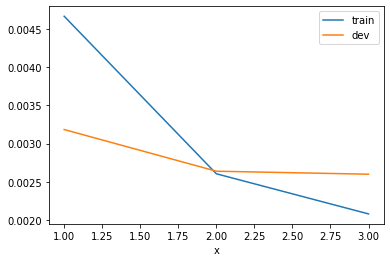

In [18]:
pd.DataFrame({'x':list(range(1, len(train_losses) + 1)), 'train':train_losses, 'dev':test_losses}).plot(x='x')

In [19]:
def calculate_confusion_matrix(features, model, batch_size):
    ''' Calculate the confusion matrix for the labels of the model '''
    
    model.cuda()
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features)):
            # add batch to gpu
            batch = tuple(t.to('cuda') for t in batch)
            b_input_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids)
            predictions.append((torch.sigmoid(raw_outputs) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)
    
def print_pct_correct(features, model):
    tmp = calculate_confusion_matrix(features, model, 80)
    print(f'Percentage correct {((tmp[1] == tmp[2]).astype(int).sum(1) == 12).sum() / tmp[1].shape[0]}')    

In [20]:
print_pct_correct(train_features, model)

Percentage correct 0.7742601246105919


In [21]:
print_pct_correct(test_features, model)

Percentage correct 0.69328125


### Evaluation

In [22]:
def load_model(filename, folder=root_folder):
    ''' Load the save model '''
    
    model = RoBERTa(len(train.columns) - 2)
        
    if n_gpu != 0:
        state = torch.load(os.path.join(folder, filename))        
        model.load_state_dict(state)        
        model.cuda()
    else:
        state = torch.load(os.path.join(folder, filename), map_location=torch.device('cpu'))             
        model.load_state_dict(state)
      
    return model

def calculate_confusion_matrix(features, model, batch_size):
    ''' Calculate the confusion matrix from a trained model '''
    
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features, batch_size, False, False)):
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
            
            logger.info(f'Step {step}')
            b_input_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids)
            predictions.append((torch.sigmoid(raw_outputs) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)

def calculate_predictions(features, model, batch_size):
    ''' Calculate the prediction from a trained model '''
    
    if n_gpu != 0:
        model.cuda()
        torch.cuda.empty_cache()

    model.eval()
    result = None

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features, batch_size, False, False)):
            logger.info(f'Step {step}')
            
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
                
            b_input_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids)
            predictions = torch.sigmoid(raw_outputs[2]).cpu()
            predictions = predictions.numpy()
            result = predictions if result is None else np.append(result, predictions, axis=0)
            
        return result

def get_label_columns(data_frame):
    ''' Return the columns with labels from the dataframe '''
    return [c for c in data_frame.columns if c not in ('Id', 'Text') and '_Pred' not in c]

def add_predictions(data_frame, features, model, batch_size):
    ''' Calculate and add the predicted values to the dataframe '''
    
    logits = calculate_predictions(features, model, batch_size)
    predictions = (logits > .5).astype(int)
    
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]

def add_predictions_to_dataframe(data_frame, predictions):
    ''' Add the model prediction to the dataframe '''
    
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]
        
class ModelResult:
    ''' Helper class used to make prediction from a trained model '''
    
    def __init__(self, data_frame, features, model, batch_size):
        confusion_matrix, labels, predictions = calculate_confusion_matrix(features, model, batch_size)
        self.confusion_matrix = confusion_matrix
        self.labels = labels
        self.predictions = predictions
        self.label_columns = get_label_columns(data_frame)
        
    def save(self, filename):
        ''' Save the model results (this object) to disk '''
        save_object(filename, self)
        
    def get_classification_report(self, output_dictionary):
        ''' Return the classification report from the model predictions '''
        
        return classification_report(self.labels, self.predictions, 
                                     target_names=self.label_columns, 
                                     output_dict=output_dictionary)
        
    def get_results_dataframe(self):
        ''' Create a summary dataframe with the results from the model '''
        
        report_dict = self.get_classification_report(True)
        label_columns = list(self.label_columns)
        label_columns.append('weighted avg')
        classification_results = pd.DataFrame({'Label':label_columns})
        classification_results['Precision'] = [report_dict[c]['precision'] for c in label_columns]
        classification_results['Recall'] = [report_dict[c]['recall'] for c in label_columns]
        classification_results['F1-Score'] = [report_dict[c]['f1-score'] for c in label_columns]
        classification_results['Support'] = [report_dict[c]['support'] for c in label_columns]
        classification_results.loc[classification_results['Label'] == 'weighted avg', 'Label'] = 'Weighted Average'
        
        return classification_results

In [23]:
model = load_model('roberta.pt', '../roberta')
model_results = ModelResult(test, test_features, model, 100)

In [24]:
model_results.save('roberta_result_test.pkl')

In [25]:
model_results = load_object('roberta_result_test.pkl')

In [26]:
add_predictions_to_dataframe(test, model_results.predictions)

<ipython-input-22-3345aaedca6d>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[f'{column_name}_Pred'] = predictions[:, i]


#### Display the evaluation results

<AxesSubplot:ylabel='Frequency'>

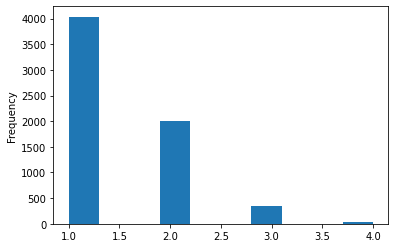

In [27]:
test[get_label_columns(test)].sum(1).plot.hist()

In [28]:
model_results.get_results_dataframe()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Label,Precision,Recall,F1-Score,Support
0,World,0.764423,0.897291,0.825545,886
1,Washington,0.711623,0.874663,0.784764,742
2,New_York_and_Region,0.926496,0.889984,0.907873,1827
3,Front_Page,0.872549,0.311189,0.458763,286
4,Business,0.943495,0.835856,0.886420,859
5,US,0.762238,0.832061,0.795620,1965
6,Sports,0.989666,0.961039,0.975142,1694
7,Obituaries,0.971223,0.996310,0.983607,271
8,Health,0.776062,0.665563,0.716578,302
9,Education,0.661972,0.602564,0.630872,78


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:ylabel='Label'>

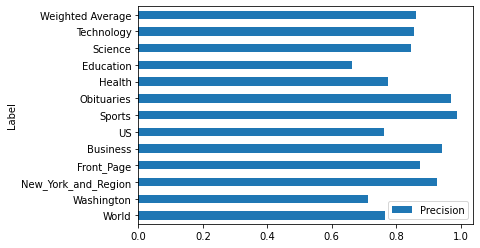

In [29]:
model_results.get_results_dataframe().plot.barh(x='Label', y='Precision')

#### Number of matches

<AxesSubplot:ylabel='Frequency'>

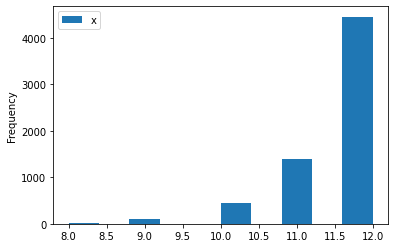

In [30]:
pd.DataFrame({'x':((model_results.labels == model_results.predictions).astype(int).sum(1))}).plot.hist()

## Saving the model

* [pytorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

* [Google Drive](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=D78AM1fFt2ty)

## Bert

* [Bert Tutorial (Hidden Layers)](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)

* [GIT Huggingface](https://github.com/huggingface/transformers/blob/master/transformers/modeling_bert.py)